# Watershed DEM Preparation

This notebook helps to create input watershed DEM files. The watershed DEM file can be used as the input DEM file for running the simulation.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import rasterio

from bmi_topography import Topography
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, ChannelProfiler
from landlab.utils import get_watershed_mask
from landlab import imshow_grid
from landlab.io import write_esri_ascii

## Step1: Download DEM data

We will use the [Topography Data Component](https://bmi-topography.csdms.io/en/latest/) to download the DEM dataset (10m resolution) for the study area.

In [2]:
# define parameters
params = {
    "dem_type": "USGS10m",
    "south": 40.11592,
    "north": 40.14016,
    "east": -105.30610,
    "west": -105.35413,
    "output_format": "GTiff",
    "cache_dir": "spruce",
}

# download data
study_area = Topography(**params)
study_area.fetch()
dataset = study_area.load()

/Users/tiga7385/anaconda3/envs/mini_project/lib/python3.12/site-packages/bmi_topography/api_key.py:49: UserWarning: You are using a demo key to fetch data from OpenTopography, functionality will be limited. See https://bmi-topography.csdms.io/en/latest/#api-key for more information.
  warnings.warn(


## Step2: Watershed Delineation

We will use the [Landlab](https://landlab.csdms.io/) model components and utitlities to do the watershed delineation for the DEM data.

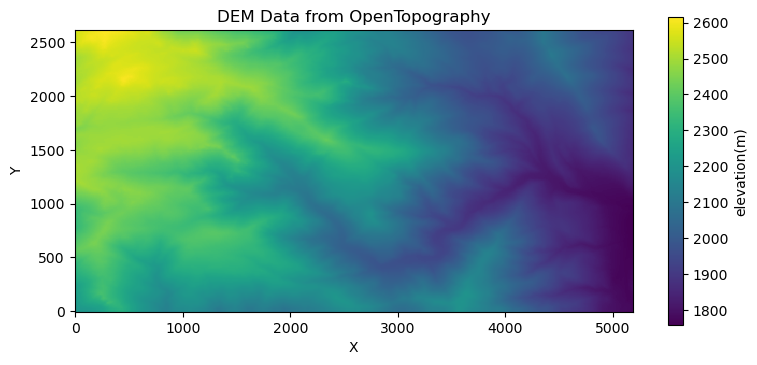

In [3]:
# set parameters
cell_size = 10  # DEM data resolution in meter
no_data = -9999  # no data value for the grid cells outside of the watershed

# define Raster Model Grid
elevation = np.flip(dataset.values[0], axis=0)
model_grid = RasterModelGrid(elevation.shape, xy_spacing=cell_size)
dem_field = model_grid.add_field("topographic__elevation", elevation.astype("float"))
model_grid.status_at_node[dem_field < 0] = (
    model_grid.BC_NODE_IS_CLOSED
)  # disable water area

# plot DEM data
plt.figure(figsize=(9, 4))
model_grid.imshow(
    "topographic__elevation",
    plot_name="DEM Data from OpenTopography",
    var_name="elevation(m)",
    cmap="viridis",
)

In [4]:
# flow accumulation
fa = FlowAccumulator(
    model_grid,
    method="Steepest",
    flow_director="FlowDirectorSteepest",
    depression_finder="LakeMapperBarnes",
    redirect_flow_steepest_descent=True,
    reaccumulate_flow=True,
)
fa.run_one_step()

# set up channel profiler
profiler = ChannelProfiler(model_grid, number_of_watersheds=1)
profiler.run_one_step()

# get watershed mask
outlet = profiler.nodes[0][0]
watershed_mask = get_watershed_mask(model_grid, outlet)

# assign nodata to cells outside the watershed
model_grid.at_node["topographic__elevation"][~watershed_mask] = no_data

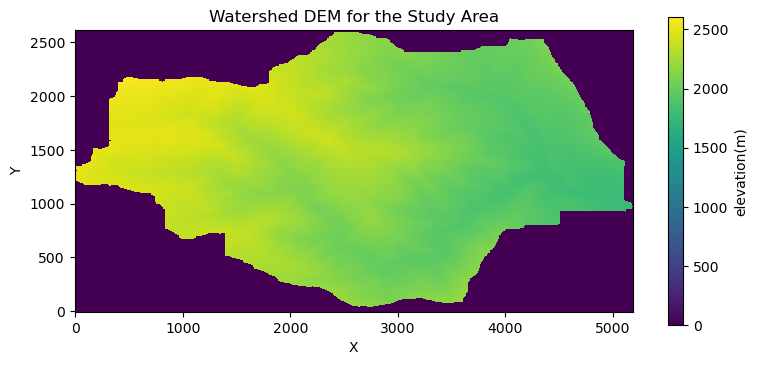

In [5]:
# plot watershed
plt.figure(figsize=(9, 4))

model_grid.imshow(
    "topographic__elevation",
    vmin=0,
    plot_name="Watershed DEM for the Study Area",
    var_name="elevation(m)",
    cmap="viridis",
)

In [6]:
# export watershed dem as ASCII file
write_esri_ascii("spruce_watershed.txt", model_grid, "topographic__elevation")

['spruce_watershed.txt']